In [1]:
from src.utils.load_processed_data import load_wine, load_glass, load_pima_diabetes
from src.naive_bayes import GaussianNaiveBayes, NaiveBayes, MixedNaiveBayes
from src.cross_validation import CrossValidator
from src.evaluators import MetricsEvaluator
from src.digitisers import (DataTransformer, DiscreteEncoder, 
                            RoundDigitizer, KMeansDigitizer, 
                            MultipleAttributeTransformer)
import time

In [2]:
import pandas as pd
import numpy as np

In [3]:
%matplotlib inline

In [4]:
from matplotlib import pyplot as plt
import seaborn as sbn

In [5]:
nb_repetitions = 100
nb_folds = 10

In [6]:
def experiment(x, y, model_initialiser, transform_initialiser=None, 
               nb_repetitions=nb_repetitions, nb_folds=nb_folds):
    tic = time.time()
    metrics_evals = []
    for _ in range(nb_repetitions):
        cv = CrossValidator(x,y, model_initialiser, transform_initialiser)
        metrics_evals += cv.kfold_cross_validation(nb_folds, shuffle=True, 
                                                   return_train_evaluators=True)
    toc = time.time()
    duration = toc-tic
    return metrics_evals, duration

# Wine

In [7]:
dataw = load_wine()
Xw, Yw = dataw
print(Xw.shape)
print(len(set(Yw)))

(178, 13)
3


In [8]:
enc = MultipleAttributeTransformer({i: DiscreteEncoder() for i in range(Xw.shape[1])})
enc.fit(Xw)
xw = enc.transform(Xw)

In [9]:
simple_wine_metrics_evals, simple_wine_time = experiment(Xw, Yw, lambda: NaiveBayes(True))

In [10]:
wine_metrics_evals, wine_time = experiment(xw, Yw, lambda: GaussianNaiveBayes())

# Glass

In [11]:
datag = load_glass()
Xg, Yg = datag
print(Xg.shape)
print(len(set(Yg)))

(214, 9)
6


In [12]:
simple_glass_metrics_evals, simple_glass_time = experiment(Xg, Yg, lambda: NaiveBayes(True))

In [13]:
discretisers = {0: None,
                1: None,
                2: KMeansDigitizer(20),
                3: None,
                4: None,
                5: KMeansDigitizer(15),
                6: None,
                7: KMeansDigitizer(5),
                8: KMeansDigitizer(5)}
discretiser_init = lambda: MultipleAttributeTransformer(discretisers)
model_init = lambda: MixedNaiveBayes([0,1,3,4,6])
glass_metrics_evals, glass_time = experiment(Xg, Yg, model_init, discretiser_init)

In [14]:
np.asarray([g.accuracy() for g in glass_metrics_evals[0]]).mean()

0.54069264069264078

# Pima Indians

In [15]:
datap = load_pima_diabetes()
Xp, Yp = datap
print(Xp.shape)
print(len(set(Yp)))

(768, 8)
2


In [16]:
simple_pima_metrics_evals, simple_pima_time = experiment(Xp, Yp, lambda: NaiveBayes(True))

In [17]:
pima_metrics_evals, pima_time = experiment(Xp, Yp, lambda: GaussianNaiveBayes())

# Plots

In [18]:
def calculate_metrics(func_call, metrics_evals):
    return (np.asarray([func_call(m) for m in metrics_evals[0]]), 
            np.asarray([func_call(m) for m in metrics_evals[1]]))

In [19]:
def calculate_metrics_avgs_stds(func_name, metrics_lists):
    means = []
    stds = []
    for mevals in metrics_lists:
        metric = np.asarray([eval('m.'+func_name+'()') for m in mevals])
        means.append(metric.mean())
        stds.append(metric.std())
    return means, stds

In [20]:
def bar_plot(df, metric_name):
    f, ax = plt.subplots(ncols=3, figsize=(18,8), sharey=True)
    sbn.set_palette('deep')
    for i, prb in enumerate(['Wine', 'Glass', 'Pima']):
        a = sbn.barplot(x='set', y='result', ci='sd',
                        data=df[df.problem==prb],
                        ax=ax[i])
        a.grid()
        a.set_xticklabels(a.get_xticklabels(), size=20)
        a.set_xlabel(prb, size=25)
        a.set_yticklabels(a.get_yticks(), size=20)
        a.set_ylabel(metric_name, size=25)

        for i, st in enumerate(df.set.unique()):
            rows = df[(df.set == st) & (df.problem == prb)]
            mean = rows.mean()
            std = rows.std()
            txt = str(float(round(mean,2))) + '±' + str(float(round(std,2)))
            a.text(i, mean/2, txt, color='black', ha="center", size=18)

In [21]:
def create_df(wa_te, wa_tr, ga_te, ga_tr, pa_te, pa_tr):
    df = pd.DataFrame([('Wine','Walidacyjny', v) for v in wa_te]
                  + [('Wine','Treningowy', v) for v in wa_tr]
                  + [('Glass','Walidacyjny', v) for v in ga_te]
                  + [('Glass','Treningowy', v) for v in ga_tr]
                  + [('Pima','Walidacyjny', v) for v in pa_te]
                  + [('Pima','Treningowy', v) for v in pa_tr])
    df.columns=['problem','set', 'result']
    return df

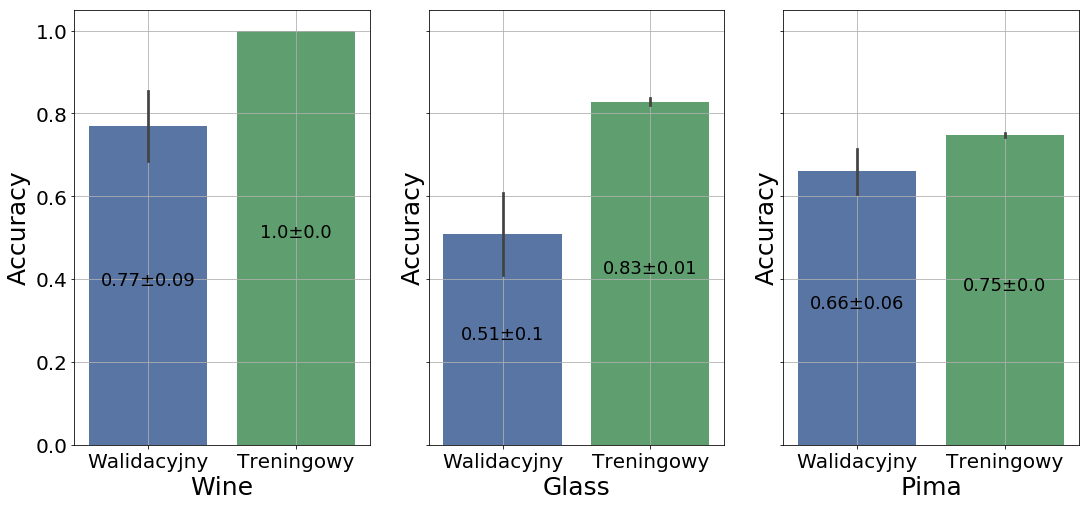

In [22]:
wa_te, wa_tr = calculate_metrics(lambda x: x.accuracy(), simple_wine_metrics_evals)
ga_te, ga_tr = calculate_metrics(lambda x: x.accuracy(), simple_glass_metrics_evals)
pa_te, pa_tr = calculate_metrics(lambda x: x.accuracy(), simple_pima_metrics_evals)

df = create_df(wa_te, wa_tr, ga_te, ga_tr, pa_te, pa_tr)
bar_plot(df, 'Accuracy')

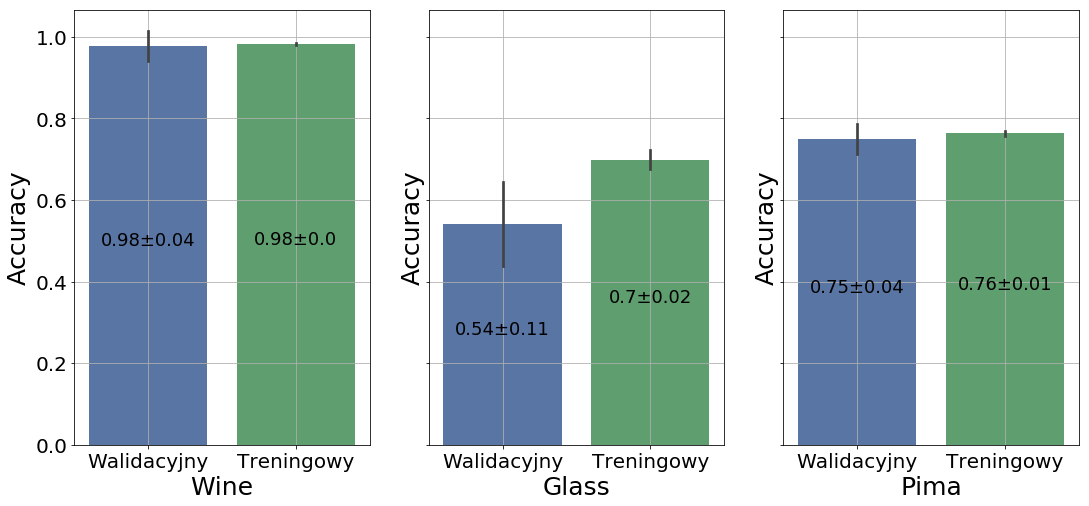

In [23]:
wa_te, wa_tr = calculate_metrics(lambda x: x.accuracy(), wine_metrics_evals)
ga_te, ga_tr = calculate_metrics(lambda x: x.accuracy(), glass_metrics_evals)
pa_te, pa_tr = calculate_metrics(lambda x: x.accuracy(), pima_metrics_evals)

df = create_df(wa_te, wa_tr, ga_te, ga_tr, pa_te, pa_tr)

bar_plot(df, 'Accuracy')

C:\Users\mkosturek\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


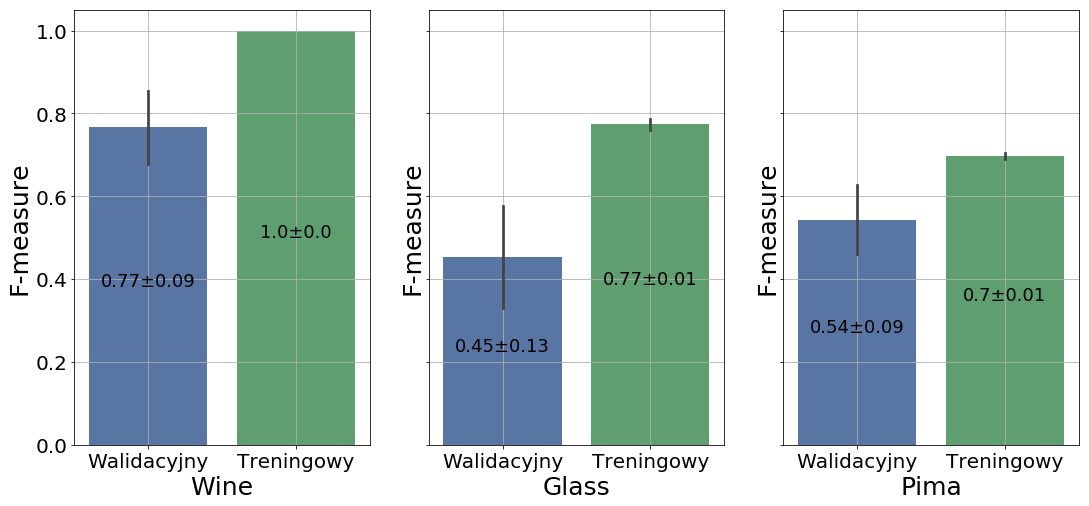

In [24]:
wf_te, wf_tr = calculate_metrics(lambda x: x.f_measure(), simple_wine_metrics_evals)
gf_te, gf_tr = calculate_metrics(lambda x: x.f_measure(), simple_glass_metrics_evals)
pf_te, pf_tr = calculate_metrics(lambda x: x.f_measure(), simple_pima_metrics_evals)

df = create_df(wf_te, wf_tr, gf_te, gf_tr, pf_te, pf_tr)
bar_plot(df, 'F-measure')

C:\Users\mkosturek\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mkosturek\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


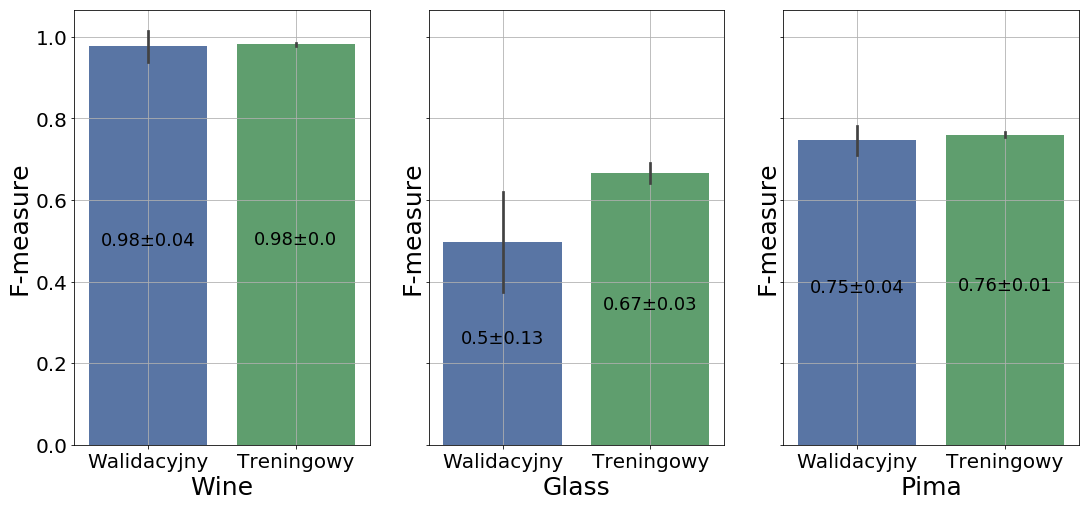

In [25]:
wf_te, wf_tr = calculate_metrics(lambda x: x.f_measure(), wine_metrics_evals)
gf_te, gf_tr = calculate_metrics(lambda x: x.f_measure(), glass_metrics_evals)
pf_te, pf_tr = calculate_metrics(lambda x: x.f_measure(), pima_metrics_evals)

df = create_df(wf_te, wf_tr, gf_te, gf_tr, pf_te, pf_tr)
bar_plot(df, 'F-measure')

In [49]:
def plot_conf_matrix(evals, axis):
    cms = np.asarray([m.confusion_matrix() for m in evals])
    means = cms.mean(axis=0)
    stds = cms.std(axis=0)
    conn = np.empty(means.shape).astype(np.str)
    conn[:,:] = ' ± '
    annots = np.core.defchararray.add(means.astype(np.str), conn)
    annots = np.core.defchararray.add(annots, stds.round(2).astype(np.str))
    
    ax = sbn.heatmap(means, annot=annots, fmt='', cmap='Blues', 
                     square=True, linewidths=1, linecolor='k', annot_kws={'size':15}, ax=axis)

    ax.set_xlabel('Predykowana klasa', size=15)
    ax.set_ylabel('Rzeczywista klasa', size=15)

Text(0.5,1,'Model dopasowany')

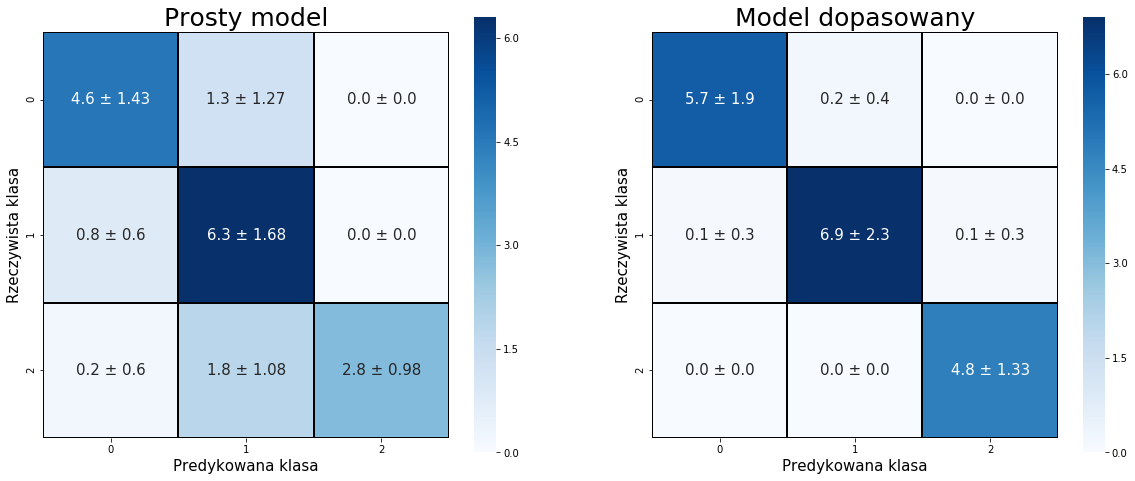

In [58]:
f, ax = plt.subplots(ncols=2, figsize=(20,8))
plot_conf_matrix(simple_wine_metrics_evals[0], ax[0])
ax[0].set_title('Prosty model', size=25)
plot_conf_matrix(wine_metrics_evals[0], ax[1])
ax[1].set_title('Model dopasowany', size=25)

Text(0.5,1,'Model dopasowany')

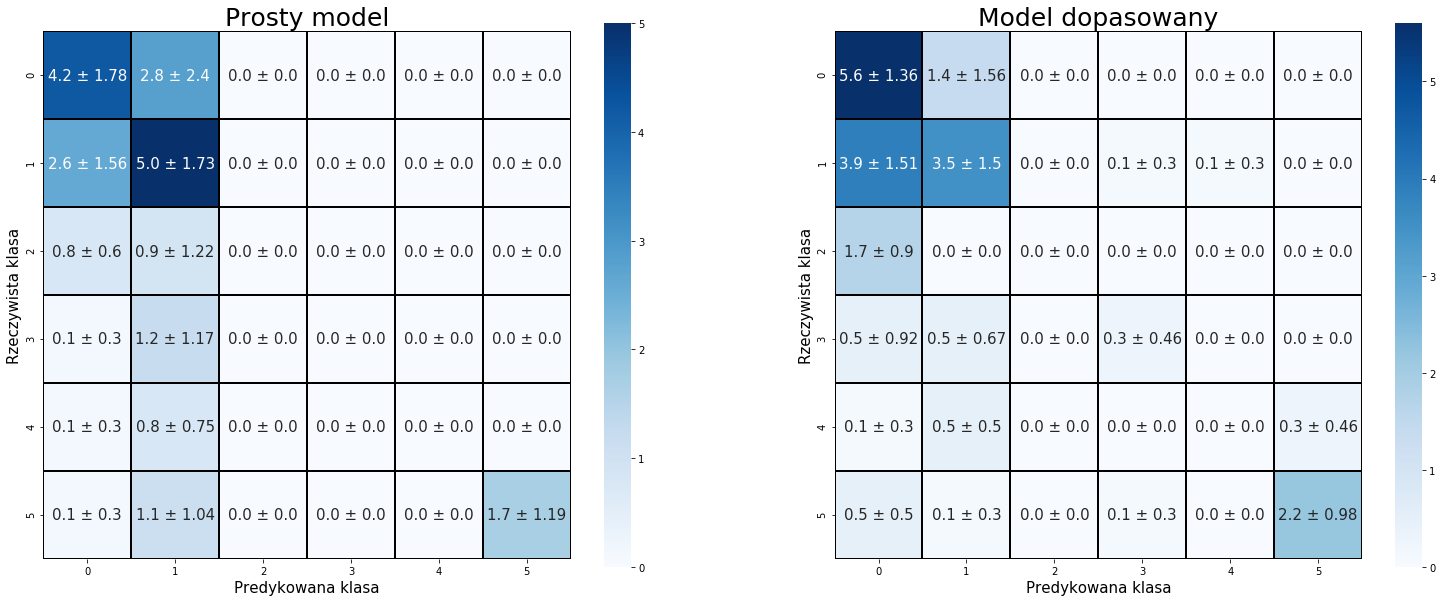

In [63]:
f, ax = plt.subplots(ncols=2, figsize=(26,10))
plot_conf_matrix(simple_glass_metrics_evals[0], ax[0])
ax[0].set_title('Prosty model', size=25)
plot_conf_matrix(glass_metrics_evals[0], ax[1])
ax[1].set_title('Model dopasowany', size=25)

Text(0.5,1,'Model dopasowany')

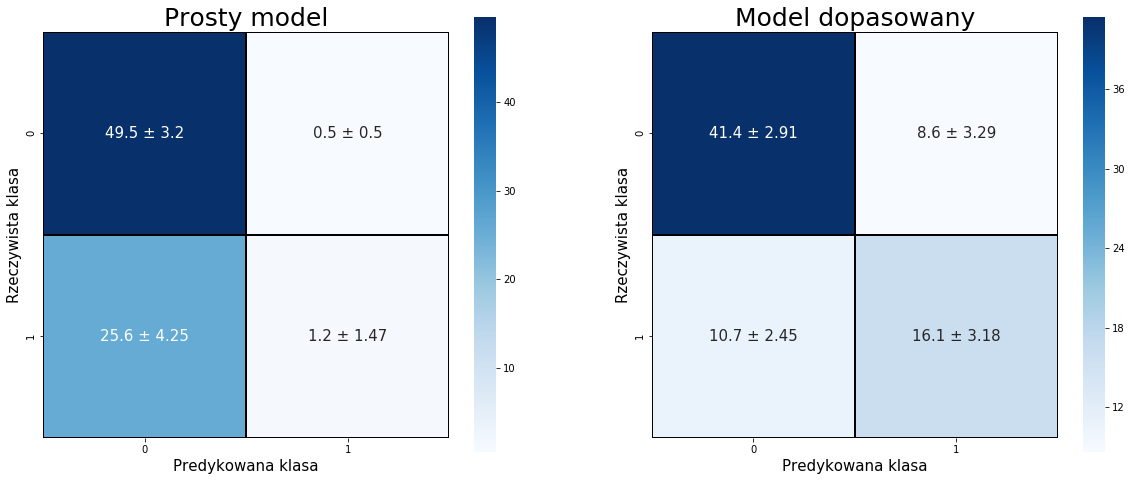

In [64]:
f, ax = plt.subplots(ncols=2, figsize=(20,8))
plot_conf_matrix(simple_pima_metrics_evals[0], ax[0])
ax[0].set_title('Prosty model', size=25)
plot_conf_matrix(pima_metrics_evals[0], ax[1])
ax[1].set_title('Model dopasowany', size=25)

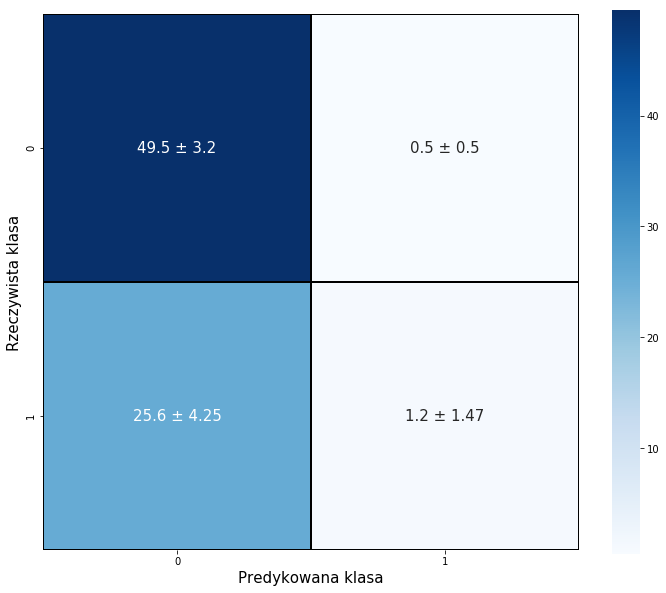

In [45]:
plot_conf_matrix(simple_pima_metrics_evals[0])

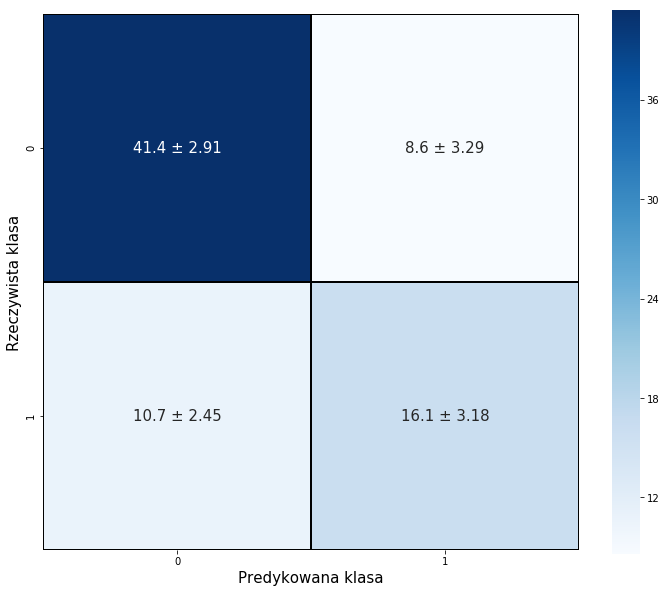

In [46]:
plot_conf_matrix(pima_metrics_evals[0])